In [2]:
import numpy as np
import math
from numpy.linalg import eig
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import scipy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel


In [5]:
def extract (csv):
    finger= csv [1:,5]
    
    return finger
    

csv =  np.genfromtxt ('hw4data/trial (1).csv', delimiter=",")
csv2 = np.genfromtxt ('hw4data/trial (2).csv', delimiter=",")
csv3 = np.genfromtxt ('hw4data/trial (3).csv', delimiter=",")
csv4 = np.genfromtxt ('hw4data/trial (4).csv', delimiter=",")
csv5 = np.genfromtxt ('hw4data/trial (5).csv', delimiter=",")

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    plt.figure(figsize=(15,15))

    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1, label='Error')
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx',  markersize=2,  label='Sample')
    plt.legend(borderpad=3)
    plt.xlabel('frame')
    plt.ylabel('position (x)')
    plt.title('Prediction with Global Hyperparameters')
    plt.show()


def plot_gpl(mu, unc, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = unc
    plt.figure(figsize=(15,15))

    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1, label='Error')
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx', markersize=2, label='Sample')
    plt.legend(borderpad=3)
    plt.xlabel('frame')
    plt.ylabel('position (x)')
    plt.title('Prediction with Local Hyperparameters')
    plt.show()
    
def extract_parameters(start,stop):
    
    #subset random_pos_vec
    
    time = tr[start:stop]
    posit = xr[start:stop]
    
    
    fitt=gpr.fit(time, posit)

    mu_s, cov_s = gpr.predict(time, return_cov=True)
    lml=gpr.log_marginal_likelihood()

    
    optimized_hyperparameters = fitt.kernel_.get_params()

    sigma = np.sqrt(list(optimized_hyperparameters.values())[4])
    noise_level = list(optimized_hyperparameters.values())[8]
    length_scale = list(optimized_hyperparameters.values())[6]
    
    
    
    return sigma, noise_level, length_scale, mu_s, cov_s, lml


def wind_slide(wind):
    hparam=np.zeros([1030,3])
    spot=0
    mu_loc=np.array([])
    uncertainty=np.array([])
    lml=0

    for i in range (math.ceil(1030/wind)):

        hparam[spot:spot+wind, 0]= extract_parameters(spot, spot+wind) [0]
        hparam[spot:spot+wind, 1]= extract_parameters(spot, spot+wind) [1]
        hparam[spot:spot+wind, 2]= extract_parameters(spot, spot+wind) [2]

        mu_loc=np.append(mu_loc, extract_parameters(spot, spot+wind) [3])
        unc = 1.96 * np.sqrt(np.diag(extract_parameters(spot, spot+wind) [4]))

        uncertainty=np.append(uncertainty, unc)
        lml=lml+extract_parameters(spot, spot+wind) [5]

        spot=spot+wind

        if (1030-spot)<wind:
            wind=1030-spot
            
    return hparam, mu_loc, uncertainty, lml

def log_l(wind):
    spot=0
    lml=0
    logml=np.array([])

    for i in range (math.ceil(1030/wind)):

        lml=lml+extract_parameters(spot, spot+wind) [5]
        logml=np.append(logml, extract_parameters(spot, spot+wind) [5])
        
        if (1030-spot)<wind:
            wind=1030-spot
               
        spot=spot+wind

            
    return lml,logml

def plot_hparam(wind):

    sigma_l=wind_slide(wind)[0][:,0]
    noise_l=wind_slide(wind)[0][:,1]
    len_l=wind_slide(wind)[0][:, 2]
    mu_loc=wind_slide(wind)[1]
    unc=wind_slide(wind)[2]
    lml=wind_slide(wind)[3]

    len_norm=len_l/600

    plt.figure(figsize=(10,10))

    plt.plot(tr,sigma_l, label='sigma_l')
    plt.plot(tr,noise_l, label='noise_l')
    plt.plot(tr, len_norm, label='len_l (normalized)')
    plt.plot(tr,sigma_g, label='sigma_g')
    plt.plot(tr,noise_g, label='noise_g')
    plt.plot(tr,len_g, label='len_g')
    plt.legend(borderpad=2)



    plt.plot(tr, xr, label='trajectory')

    plt.ylim(-2, 2)




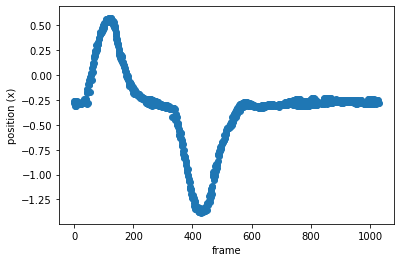

In [29]:
x = extract(csv)
x2 = extract(csv2)
x3 = extract(csv3)
x4 = extract(csv4)
x5 = extract(csv5)

mat=np.zeros([1030, 5])
mat=[x, x2, x3, x4, x5]

tr=np.zeros(1030)
xr=np.zeros(1030)

for i in range (1030):
    xr[i]= mat[np.random.randint(4)][i]
    tr[i]= i
    
plt.scatter(tr, xr)
plt.xlabel('frame')
plt.ylabel('position (x)')
plt.show()

tr=tr.reshape(-1,1)
xr=xr.reshape(-1,1)

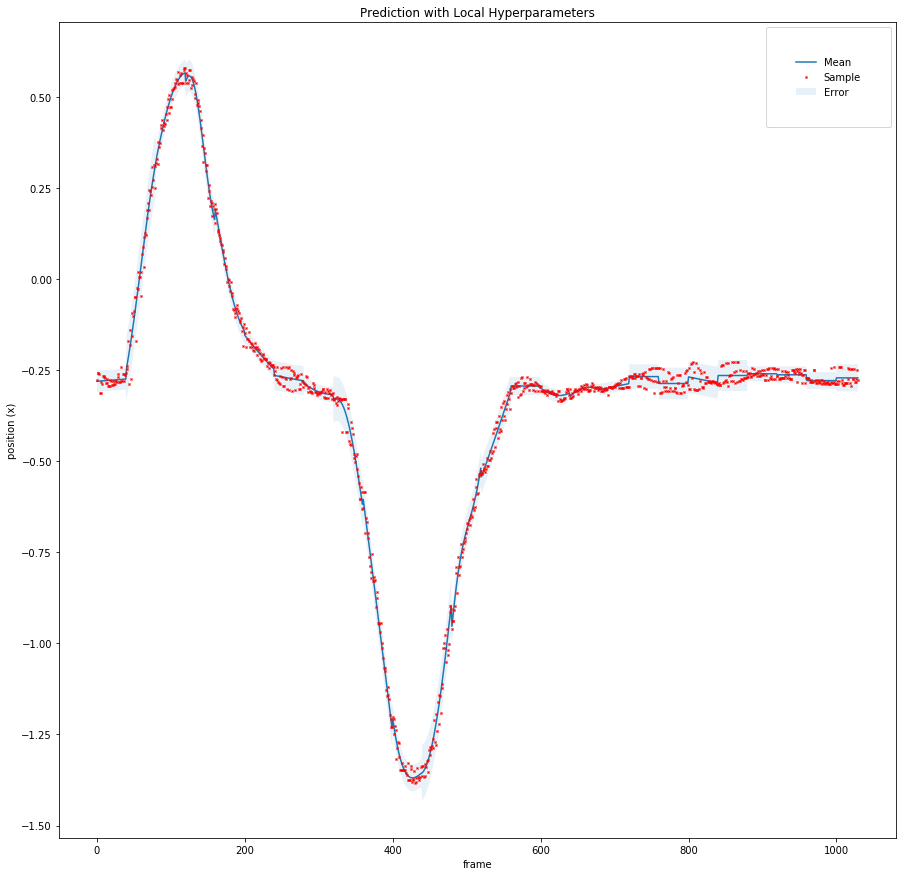

In [115]:
mu_loc=wind_slide(40)[1]
unc=wind_slide(40)[2]
plot_gpl(mu_loc, unc, tr , X_train=tr, Y_train=xr)

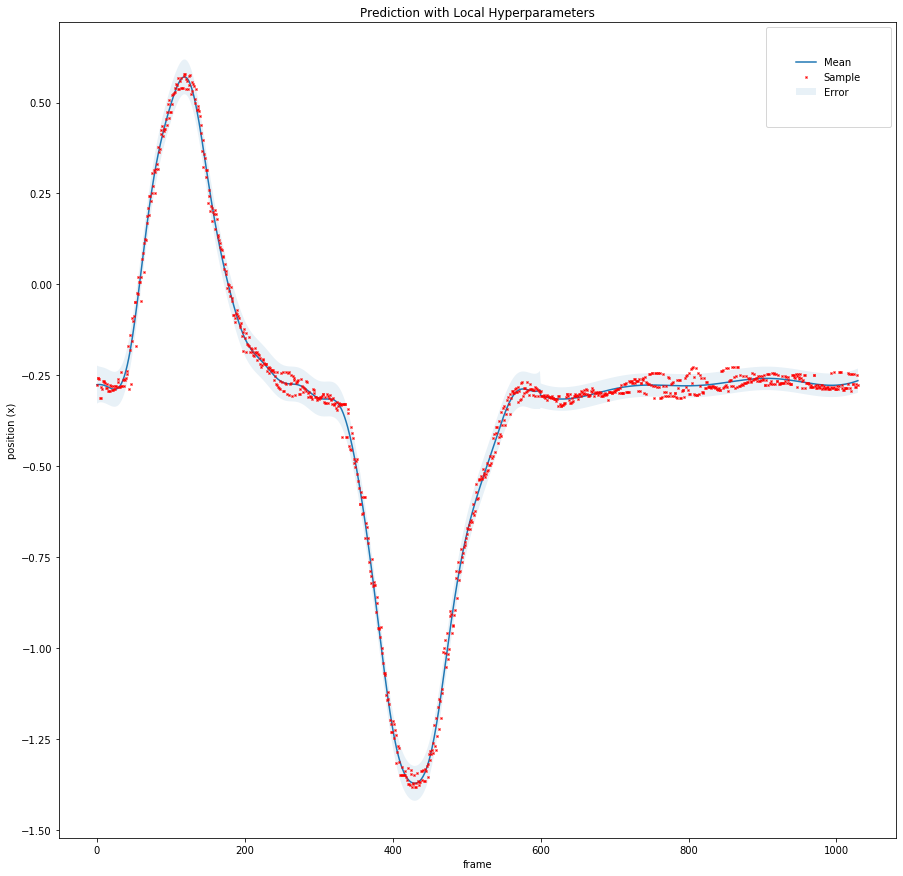

In [80]:
mu_loc=wind_slide(600)[1]
unc=wind_slide(600)[2]
plot_gpl(mu_loc, unc, tr , X_train=tr, Y_train=xr)

In [4]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)+WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

gpr = GaussianProcessRegressor(kernel=rbf, alpha=0)

# Reuse training data from previous 1D example
fitt=gpr.fit(tr, xr)

# Compute posterior predictive mean and covariance
mu_s, cov_s = gpr.predict(tr, return_cov=True)
lml_g=gpr.log_marginal_likelihood()
optimized_hyperparameters = fitt.kernel_.get_params()

sigma_g=np.zeros(1030)
noise_g=np.zeros(1030)
len_g=np.zeros(1030)

sigma_g[0:1030] = np.sqrt(list(optimized_hyperparameters.values())[4])
noise_g[0:1030] = list(optimized_hyperparameters.values())[8]
len_g[0:1030] = list(optimized_hyperparameters.values())[6]

# Plot the results
plot_gp(mu_s, cov_s, tr , X_train=tr, Y_train=xr)
 


NameError: name 'tr' is not defined

In [3]:
np.shape(mu_s)

NameError: name 'mu_s' is not defined

In [181]:
sigma_l=wind_slide(100)[0][:,0]
noise_l=wind_slide(100)[0][:,1]
len_l=wind_slide(100)[0][:, 2]
mu_loc=wind_slide(100)[1]
unc=wind_slide(100)[2]
lml=wind_slide(100)[3]



(-2, 2)

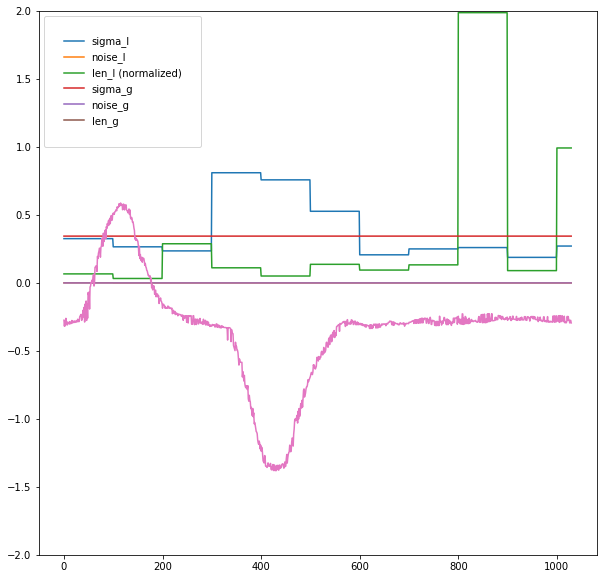

In [220]:
len_norm=len_l/600

plt.figure(figsize=(10,10))

plt.plot(tr,sigma_l, label='sigma_l')
plt.plot(tr,noise_l, label='noise_l')
plt.plot(tr, len_norm, label='len_l (normalized)')
plt.plot(tr,sigma_g, label='sigma_g')
plt.plot(tr,noise_g, label='noise_g')
plt.plot(tr,len_g, label='len_g')
plt.legend(borderpad=2)



plt.plot(tr, xr, label='trajectory')

plt.ylim(-2, 2)

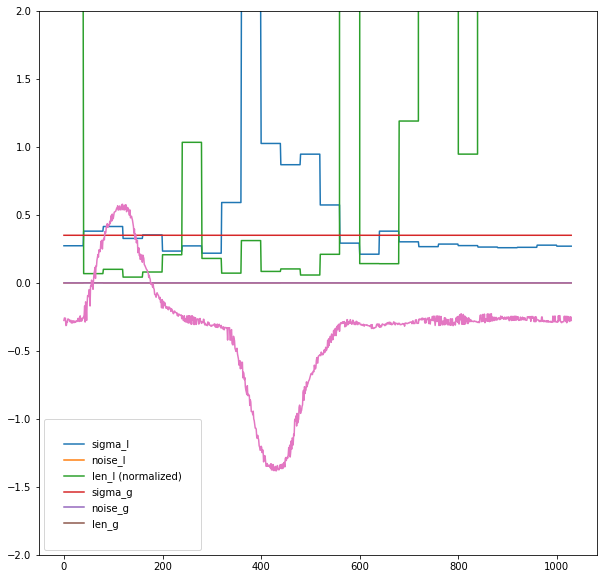

In [114]:
plot_hparam(40)



windmax:  10
maxi:  2426.6017504655547
windmax:  20
maxi:  2530.967259076675
windmax:  30
maxi:  2554.0715156977044
windmax:  40
maxi:  2567.596669736396


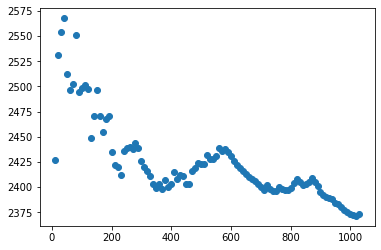

In [109]:
maxi=0
windmax=0
logml=np.array([])
window=np.array([])
for i in range (math.ceil(1030/10)):
    lml=log_l((i+1)*10)[0]
    logml=np.append(logml, lml)
    window=np.append(window,((i+1)*10))
    if (lml>maxi):
        maxi=lml
        windmax=((i+1)*10)
        print('windmax: ', windmax)
        print('maxi: ',  maxi)

plt.scatter(window, logml)


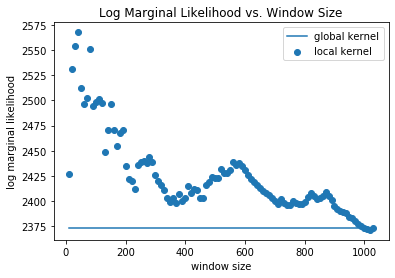

In [117]:
lml_g=np.zeros(103)
lml_g[0:103]=logml[102]
plt.scatter(window, logml, label='local kernel')
plt.plot(window,lml_g, label='global kernel')
plt.ylabel('log marginal likelihood')
plt.xlabel('window size')
plt.title('Log Marginal Likelihood vs. Window Size')
plt.legend()

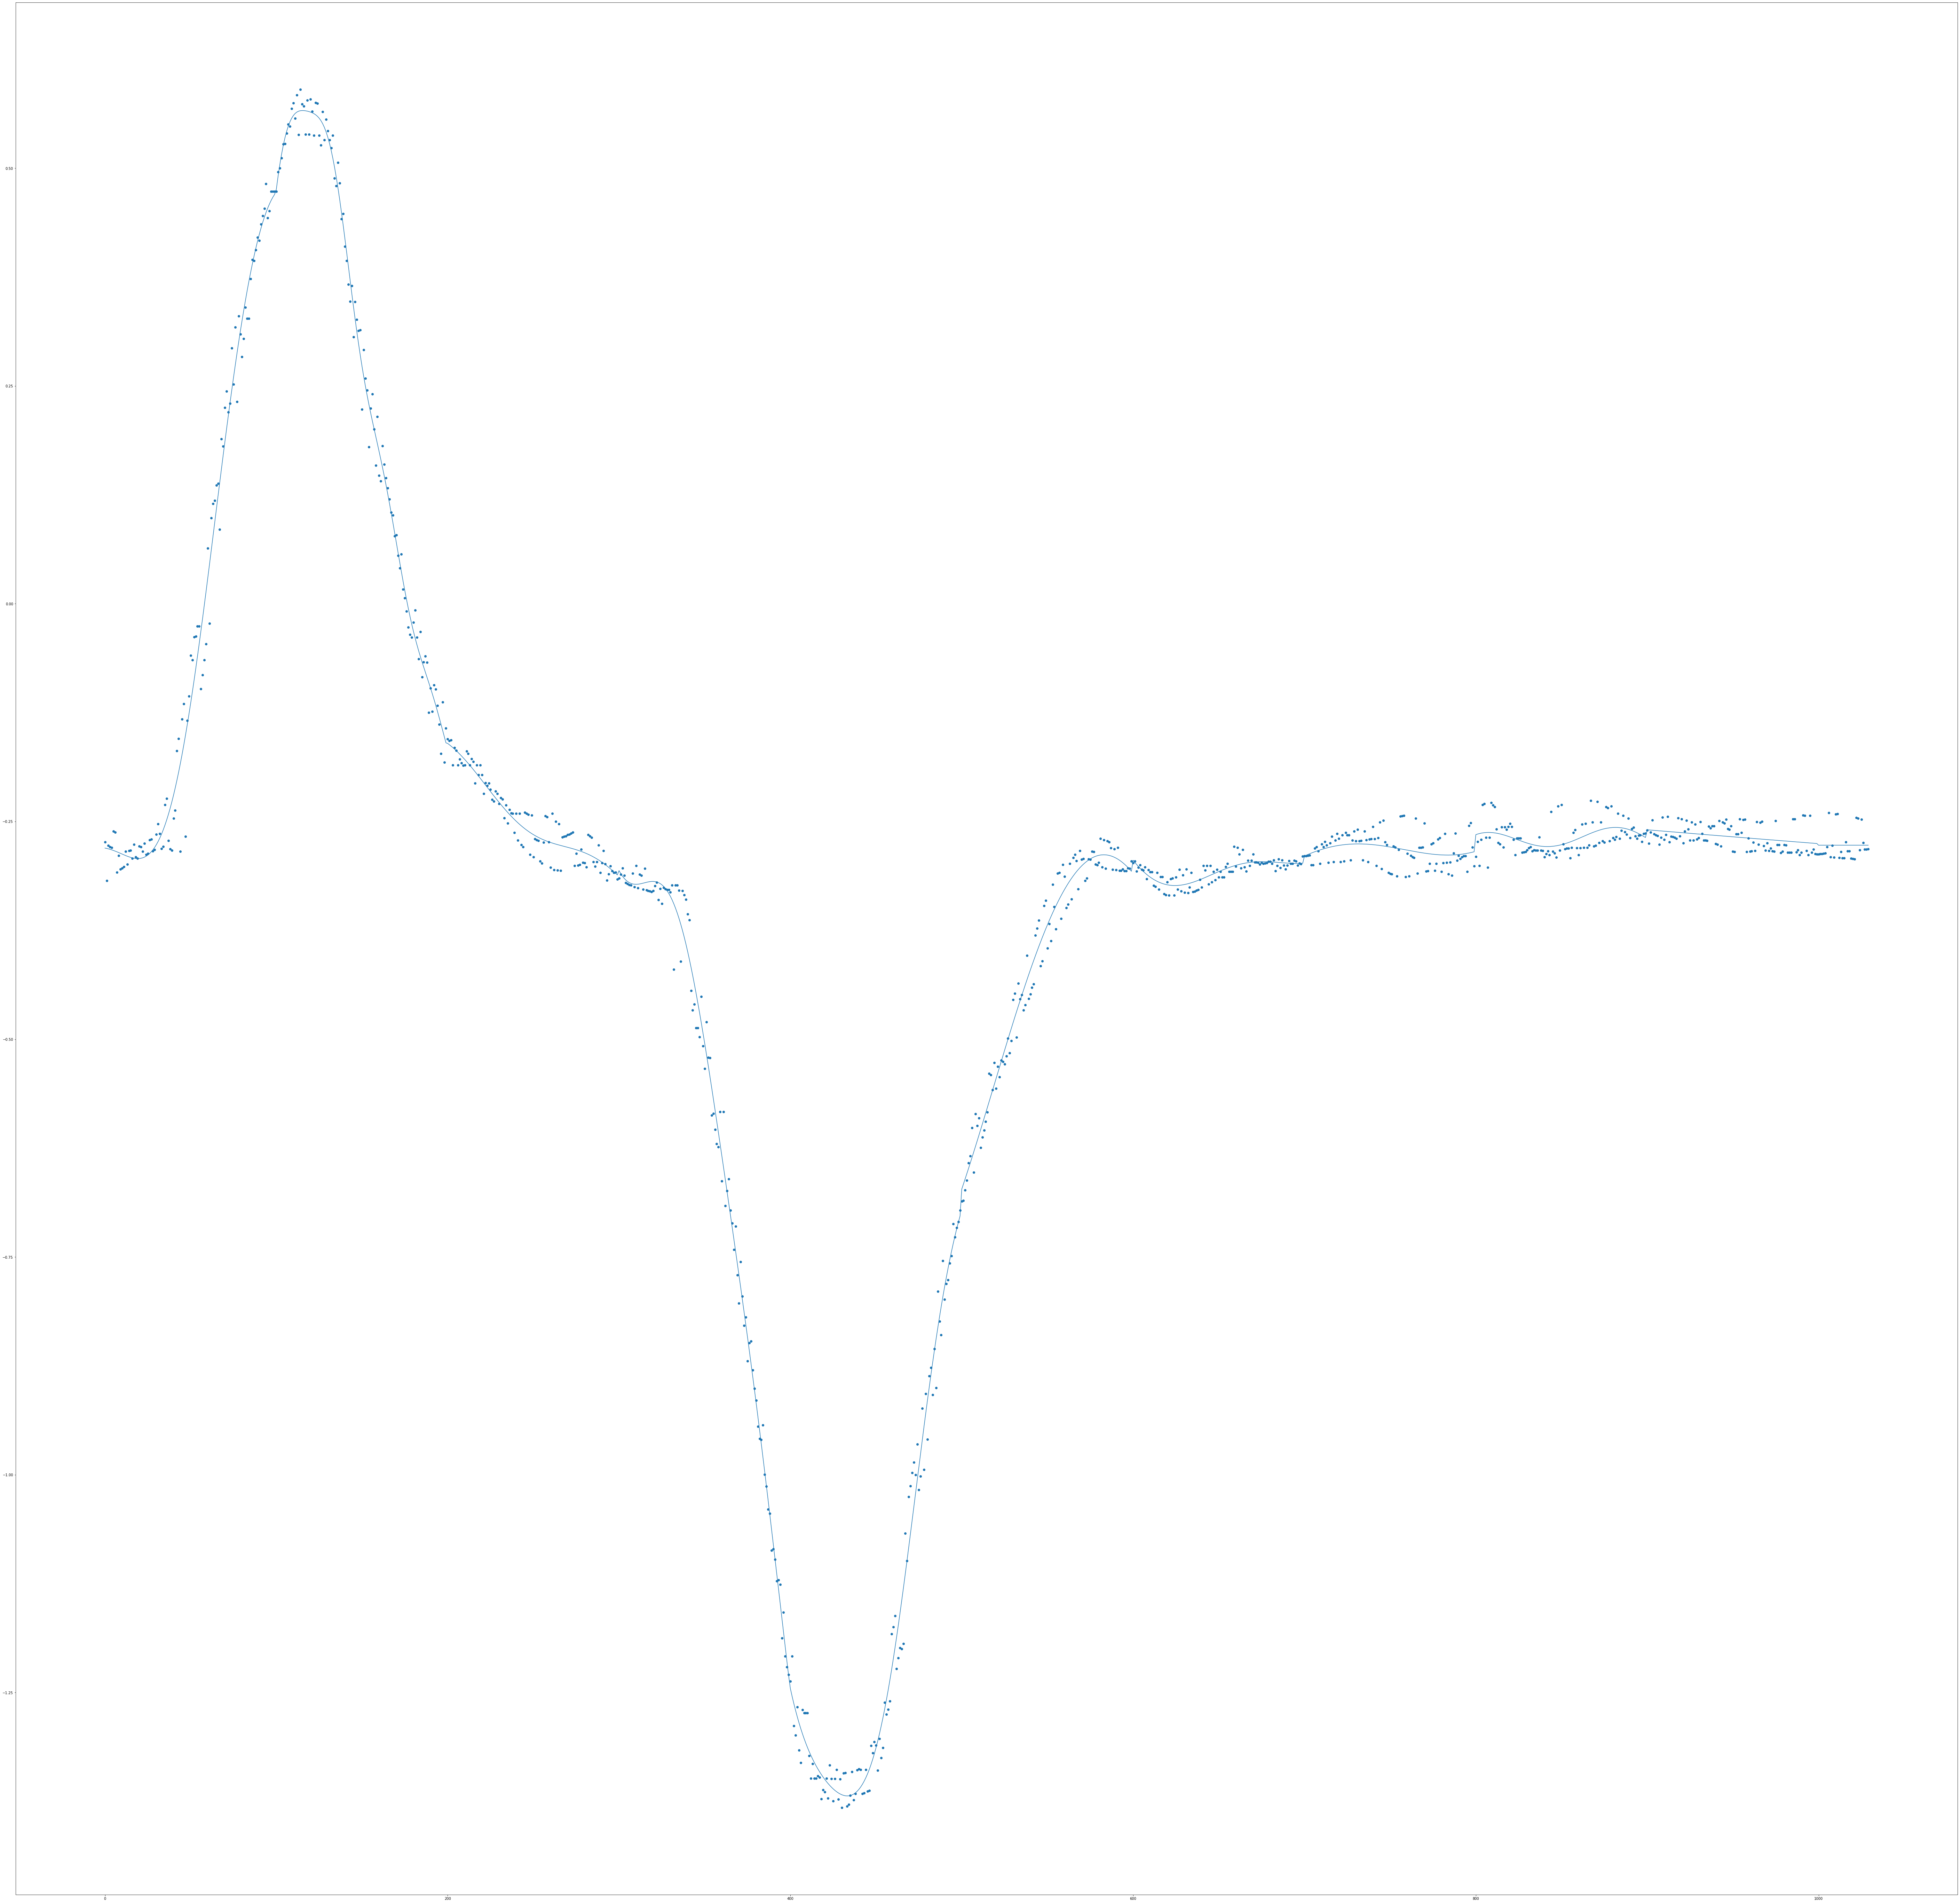

In [13]:
plt.figure(figsize=(100,100))
plt.plot(tr, mu_loc)
plt.scatter(tr, xr)


In [170]:
lml

2482.2111509919364

In [171]:
like

2351.1326917598926

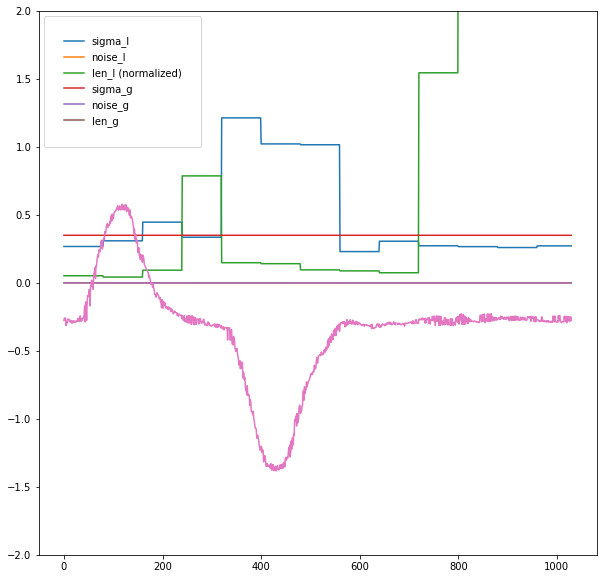

In [104]:
plot_hparam(80)


In [81]:
log_l(25)[0]

2760.283187692855

In [82]:
log_l(600)[]

2591.5568353358094

In [83]:
log_l(950)[1]

4338.700402051669

In [96]:
log_l(1030)

(2373.5732882042003, array([2373.5732882]))

In [93]:
log_l(600)

(2430.6416571970412, array([1295.77841767, 1134.86323953]))

In [94]:
log_l(25)

(2509.656382331171,
 array([65.72102828, 41.32986679, 40.63856225, 51.95766077, 60.33063946,
        52.26432671, 57.97837907, 57.92572837, 67.85293711, 66.60417776,
        55.79415828, 70.05081845, 75.75426025, 41.19178078, 42.23409259,
        54.17775835, 53.06856482, 58.39299982, 36.92988002, 41.98935334,
        57.79450611, 51.97056345, 54.92413128, 73.19339676, 87.71386844,
        73.04287953, 83.25176908, 89.22113801, 71.88228035, 65.66587243,
        51.01358847, 57.54195479, 50.13458314, 63.40212354, 55.87167182,
        80.51544456, 69.23024338, 72.91120195, 68.65921767, 70.45498847,
        58.6056113 , 10.46837452]))

In [103]:
log_l(5)

(2198.554189098433,
 array([ 8.34764704, 10.53087988, 13.1104826 , 13.27377031, 14.96423569,
        12.76716936,  9.55776977, 12.3576251 ,  4.84439042,  4.81327795,
         6.12702985, 11.1849448 ,  7.85991978,  9.54168941,  8.7336973 ,
         7.59091346,  8.09544264,  8.02910828, 10.47265315,  8.44185466,
        11.12059915, 11.91342601,  9.72763358,  9.70309879,  9.13633536,
         8.39066604,  7.84115999, 11.14033781,  6.67402442,  8.11832523,
         8.74085959,  8.93295803, 10.17781651, 18.54416578, 11.53733094,
        13.68632217, 10.16029351, 11.99168318, 14.0073251 ,  8.27535274,
         9.73295582, 11.19173543, 12.40903655, 12.5664861 , 12.00971571,
        16.30232128, 13.46067167, 11.4164257 ,  9.63060071,  9.43555186,
         8.73962001,  7.48373099,  8.69780834,  8.92469518,  9.9783001 ,
        10.67868533, 11.56196064, 13.80968725, 11.26148028, 16.19366786,
        17.74045229, 11.5255808 , 11.23925709, 11.88046198, 13.26613691,
        13.80056201,  6.0049752